Missing data count:
 Unnamed: 0     0
Category       0
Age            0
Sex            0
ALB            1
ALP           18
ALT            1
AST            0
BIL            0
CHE            0
CHOL          10
CREA           0
GGT            0
PROT           1
dtype: int64

Number of outliers in each column (Z-score > 3):
 Unnamed: 0     0
Age            0
ALB           13
ALP            3
ALT           10
AST           14
BIL            7
CHE            9
CHOL           7
CREA           3
GGT           10
PROT           9
dtype: int64


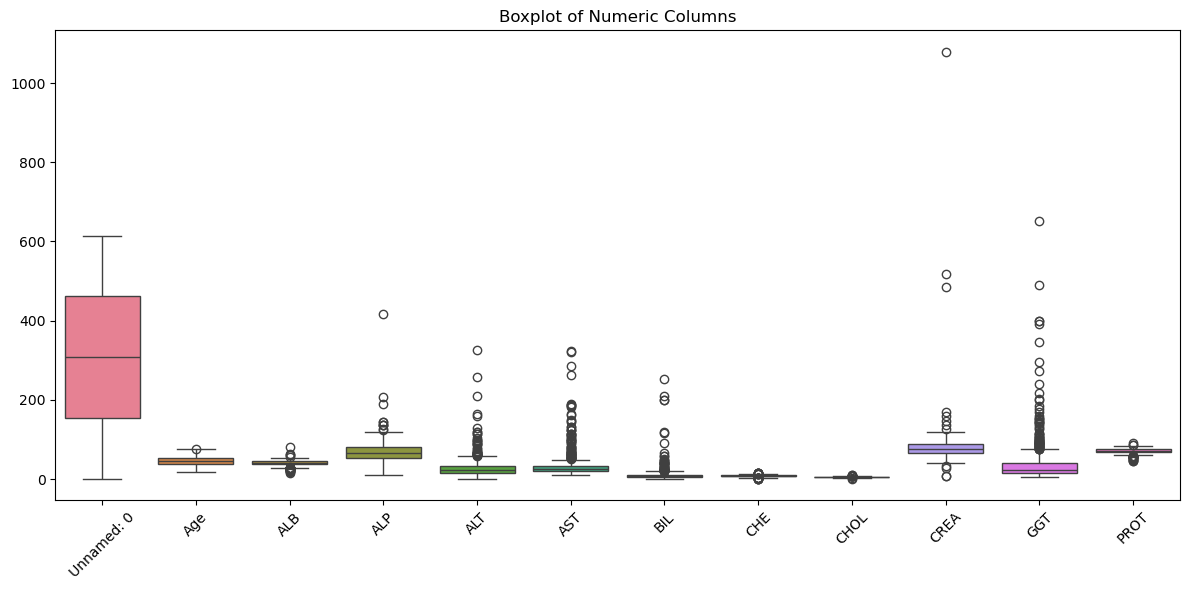


Skewness of each numeric feature:
        Feature   Skewness                 Category
0         CREA  15.169291            Highly Skewed
1          BIL   8.385437            Highly Skewed
2          GGT   5.632734            Highly Skewed
3          ALT   5.506114            Highly Skewed
4          AST   4.940327            Highly Skewed
5          ALP   4.654921            Highly Skewed
6         CHOL   0.375828  Approximately Symmetric
7          Age   0.267134  Approximately Symmetric
8   Unnamed: 0   0.000000  Approximately Symmetric
9          CHE  -0.110233  Approximately Symmetric
10         ALB  -0.176768  Approximately Symmetric
11        PROT  -0.963687        Moderately Skewed

Number of features in each skewness category:
 Category
Highly Skewed              6
Approximately Symmetric    5
Moderately Skewed          1
Name: count, dtype: int64


In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load the dataset
df = pd.read_csv("hcvdata.csv", encoding="latin-1")

# 2. Display missing values
print("Missing data count:\n", df.isnull().sum())

# 3. Select numeric columns
numeric_cols = df.select_dtypes(include='number').columns

# 4. Outlier Detection using Z-score
z_scores = np.abs((df[numeric_cols] - df[numeric_cols].mean()) / df[numeric_cols].std())
outlier_mask = z_scores > 3
outlier_counts = outlier_mask.sum()
print("\nNumber of outliers in each column (Z-score > 3):\n", outlier_counts)

# 5. Optional: View rows with outliers
#rows_with_outliers = df[outlier_mask.any(axis=1)]
#print("\nRows with any outliers:\n", rows_with_outliers)

# 6. Visualize outliers using boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[numeric_cols])
plt.xticks(rotation=45)
plt.title("Boxplot of Numeric Columns")
plt.tight_layout()
plt.show()

# 7. Skewness Analysis
skewness = df[numeric_cols].skew().sort_values(ascending=False)

# Categorize skewness
def categorize_skew(value):
    if value > 1 or value < -1:
        return "Highly Skewed"
    elif 0.5 < value <= 1 or -1 <= value < -0.5:
        return "Moderately Skewed"
    else:
        return "Approximately Symmetric"

skew_df = pd.DataFrame({
    'Feature': skewness.index,
    'Skewness': skewness.values,
    'Category': skewness.apply(categorize_skew).values
})

print("\nSkewness of each numeric feature:\n", skew_df)

# 8. Count features by skewness category
print("\nNumber of features in each skewness category:\n", skew_df['Category'].value_counts())


Missing values after imputation:
 Unnamed: 0    0
Category      0
Age           0
Sex           0
ALB           0
ALP           0
ALT           0
AST           0
BIL           0
CHE           0
CHOL          0
CREA          0
GGT           0
PROT          0
dtype: int64

Skewness of numerical columns after transformation:
ALB    -0.817669
ALP    -0.317343
ALT    -0.166088
AST     1.815691
BIL     1.101718
CHE    -0.274983
CHOL    0.359162
CREA    0.042370
GGT     0.931163
PROT   -0.738850
dtype: float64


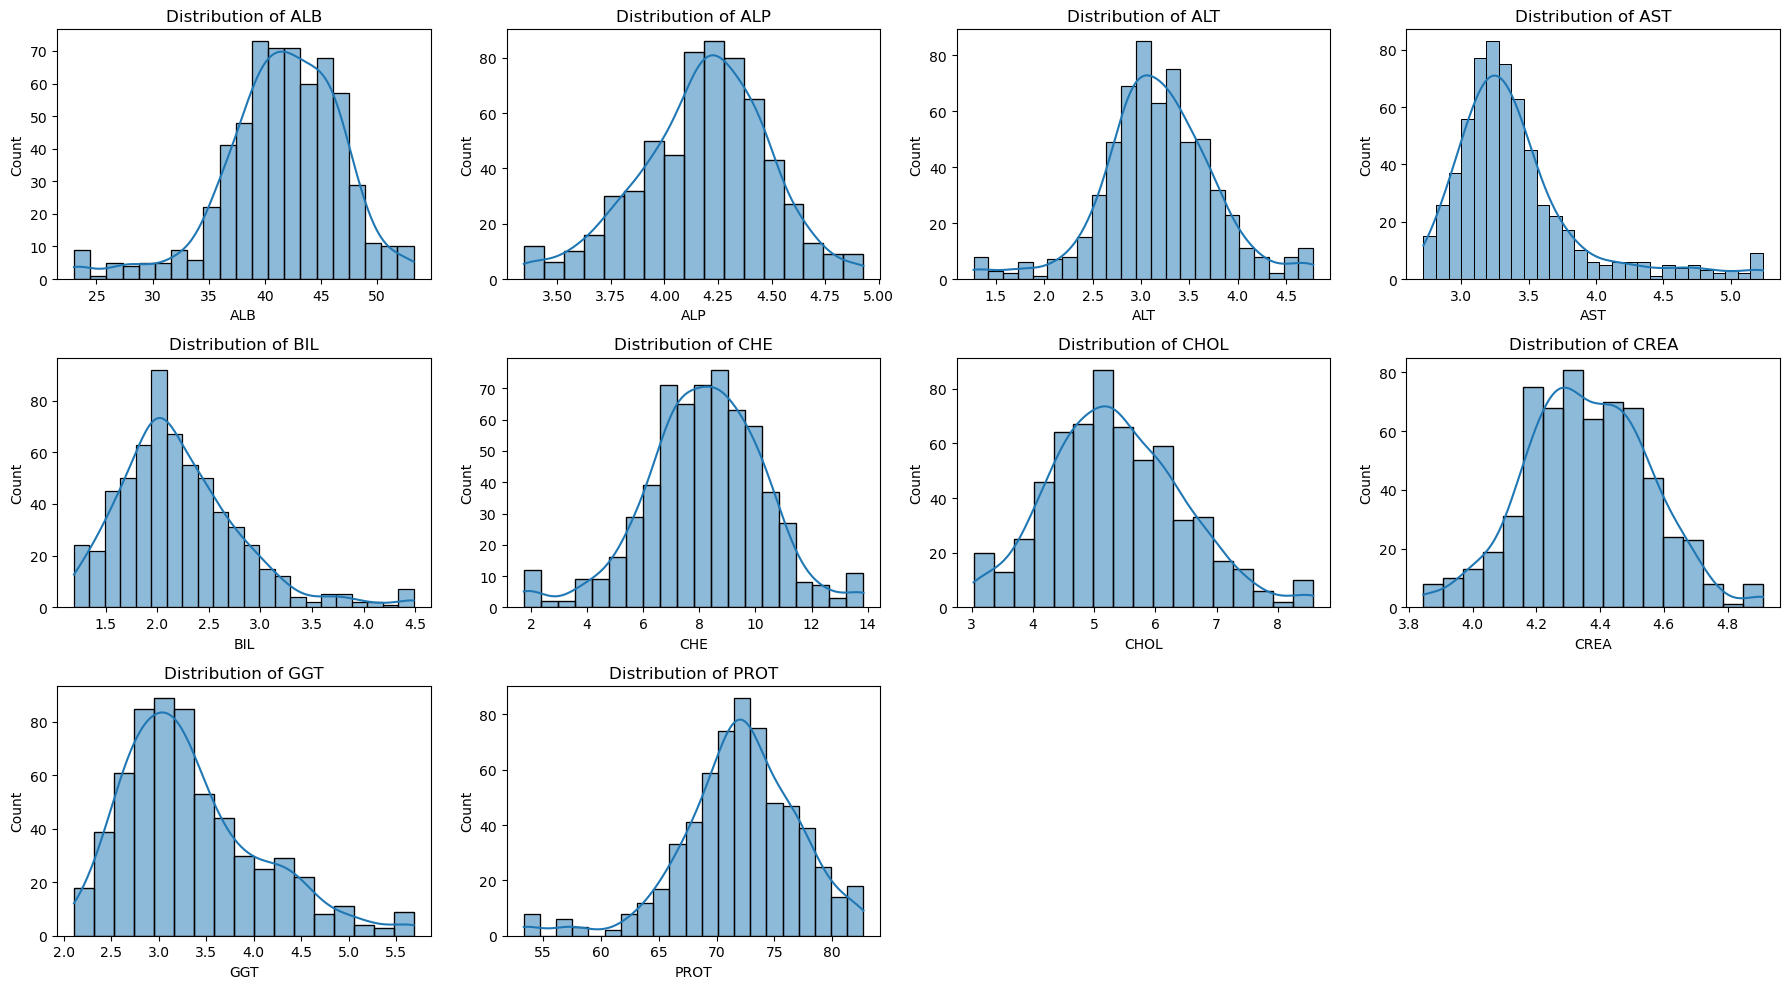

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load Dataset
df = pd.read_csv("hcvdata.csv", encoding="latin-1")

# Handle Missing Values (median)
cols_with_missing = ['ALB', 'ALP', 'ALT', 'CHOL', 'PROT']
for col in cols_with_missing:
    median_value = df[col].median()
    df[col] = df[col].fillna(median_value)

# Handle Outliers (Clipping)
numerical_cols = ['ALB', 'ALP', 'ALT', 'AST', 'BIL', 'CHE', 'CHOL', 'CREA', 'GGT', 'PROT']
for col in numerical_cols:
    lower, upper = df[col].quantile([0.01, 0.99])
    df[col] = np.clip(df[col], lower, upper)

# Apply Log Transformation to Highly Skewed Columns
highly_skewed_cols = ['CREA', 'BIL', 'GGT', 'ALT', 'AST', 'ALP']
for col in highly_skewed_cols:
    if (df[col] >= 0).all():  # Ensure no negative values
        df[col] = np.log1p(df[col])  # Safe log transform: log(1 + x)
    else:
        print(f"Skipped {col} due to negative values.")

# Confirm no missing values remain
print("\nMissing values after imputation:\n", df.isnull().sum())

# Recheck Skewness
print("\nSkewness of numerical columns after transformation:")
print(df[numerical_cols].skew())

# Plot histograms to visualize final distributions
plt.figure(figsize=(18, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 4, i+1)
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

# Save cleaned dataset
df.to_excel("Cleaned_Dataset.xlsx", index=False)

In [7]:
import pandas as pd
from sklearn.preprocessing import RobustScaler, LabelEncoder

# Load the cleaned dataset
df = pd.read_excel("Cleaned_Dataset.xlsx")

# Step 1: Encode the 'Sex' column (categorical)
if 'Sex' in df.columns:
    le_sex = LabelEncoder()
    df['Sex'] = le_sex.fit_transform(df['Sex'])  # 'm' → 1, 'f' → 0

# Step 2: Encode the 'Category' column to create a binary 'Target'
df['Target'] = df['Category'].map({
    '0=Blood Donor': 0, #blood donor (0)
    '0s=suspect Blood Donor': 1, #non-blood donor (1)
    '1=Hepatitis': 1, 
    '2=Fibrosis': 1,
    '3=Cirrhosis': 1
}).astype(int)

# Step 3: Drop unnecessary columns (optional)
df.drop(columns=['Unnamed: 0', 'Category'], inplace=True)

# Step 4: Define numerical columns for standardization
numerical_cols = ['Age', 'ALB', 'ALP', 'ALT', 'AST', 'BIL', 
                  'CHE', 'CHOL', 'CREA', 'GGT', 'PROT']

# Step 5: Standardize numerical features using RobustScaler
scaler = RobustScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Preview the result
print(df.head())

# Step 6: (Optional) Save the fully preprocessed dataset
df.to_excel("Preprocessed_Dataset.xlsx", index=False)

# Confirmation message
print("Preprocessed dataset saved as 'Preprocessed_Dataset.xlsx'")

   Age  Sex       ALB       ALP       ALT       AST       BIL       CHE  \
0 -1.0    1 -0.539062 -0.573258 -1.511458 -0.375602  0.036028 -0.500942   
1 -1.0    1 -0.539062  0.148909 -0.347973 -0.112550 -0.797445  1.096045   
2 -1.0    1  0.773437  0.299475  0.652788  1.700326 -0.236290  0.218456   
3 -1.0    1  0.195312 -0.596867  0.409771 -0.322789  1.323169 -0.350282   
4 -1.0    1 -0.429687  0.279467  0.501181 -0.102973  0.370107  0.335217   

       CHOL      CREA       GGT      PROT  Target  
0 -1.442509  1.174605 -0.684213 -0.524590       0  
1 -0.348432 -0.145732 -0.421995  0.704918       0  
2 -0.069686  0.405751  0.378448  1.163934       0  
3 -0.390244  0.140232  0.397707  0.573770       0  
4 -0.682927 -0.047945  0.266082 -0.573770       0  
Preprocessed dataset saved as 'Preprocessed_Dataset.xlsx'


In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score
)

# Load the preprocessed dataset
df = pd.read_excel("Preprocessed_Dataset.xlsx")

# Initialize lists to store metrics
train_test_labels = []
accuracies = []
precisions = []
recalls = []
f1_scores = []
roc_aucs = []

# Define features and target
selected_features = ['Age','Sex', 'ALB', 'ALP', 'ALT', 'AST', 'BIL','CHE', 'CHOL', 'CREA', 'GGT', 'PROT'] 
X = df[selected_features]
y = df['Target']

# Define train-test split ratios
split_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Evaluate model across different splits
for test_ratio in split_ratios:
    train_ratio = 1 - test_ratio
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_ratio, random_state=42, stratify=y
    )

    # Train logistic regression model
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)

    # Predict labels and probabilities
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Store results
    train_test_labels.append(f"{round(train_ratio*100)}:{round(test_ratio*100)}")
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    roc_aucs.append(roc_auc_score(y_test, y_proba))

# Combine results into a single DataFrame
results_df = pd.DataFrame({
    'Train:Test Ratio': train_test_labels,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1_scores,
    'ROC AUC': roc_aucs
})

# Display the final evaluation summary
print("\nLogistic Regression Performance Summary:")
print(results_df)


Logistic Regression Performance Summary:
  Train:Test Ratio  Accuracy  Precision    Recall  F1 Score   ROC AUC
0            90:10  1.000000   1.000000  1.000000  1.000000  1.000000
1            80:20  0.991870   1.000000  0.937500  0.967742  1.000000
2            70:30  0.978378   1.000000  0.840000  0.913043  0.996500
3            60:40  0.975610   1.000000  0.818182  0.900000  0.996301
4            50:50  0.967532   0.969697  0.780488  0.864865  0.987942
5            40:60  0.953930   0.900000  0.734694  0.808989  0.964286
6            30:70  0.955916   0.931818  0.719298  0.811881  0.973637
7            20:80  0.945122   0.914894  0.651515  0.761062  0.967172
8            10:90  0.945848   0.958333  0.621622  0.754098  0.959600


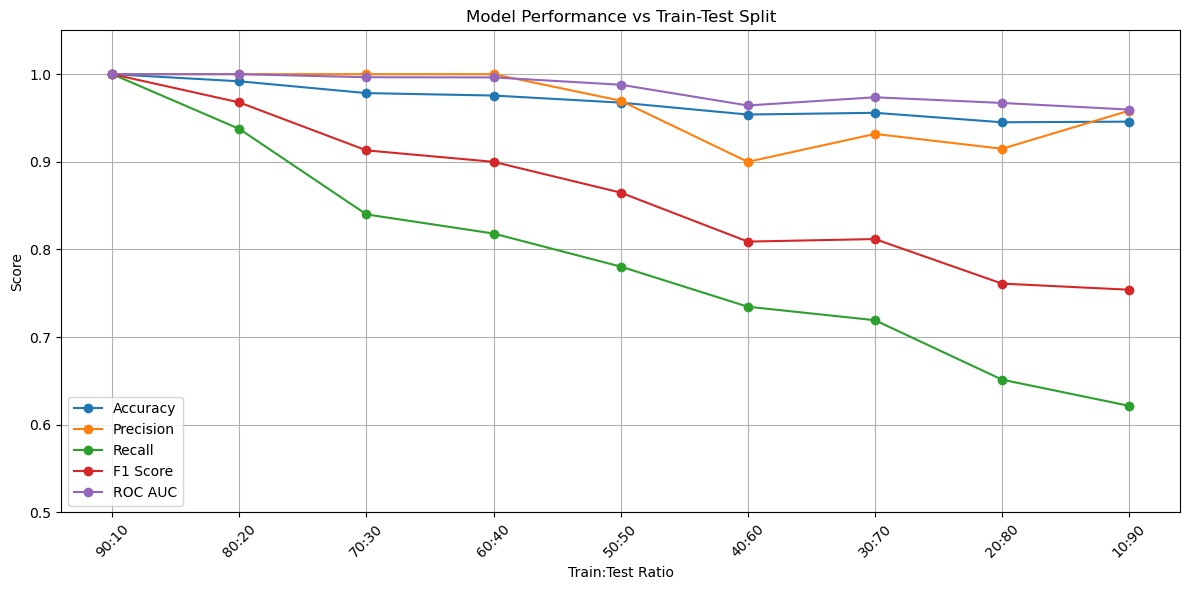

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming `results_df` already exists with metric columns
# If not, load it from Excel or generate it before this

# Plot metrics vs Train:Test Ratio
plt.figure(figsize=(12, 6))
for metric in ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']:
    plt.plot(results_df['Train:Test Ratio'], results_df[metric], marker='o', label=metric)

plt.title('Model Performance vs Train-Test Split')
plt.xlabel('Train:Test Ratio')
plt.ylabel('Score')
plt.ylim(0.5, 1.05)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

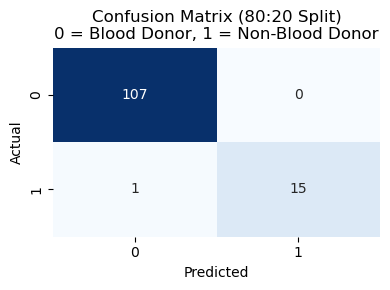

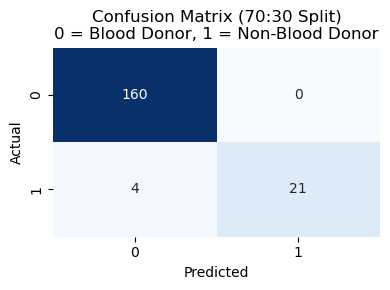

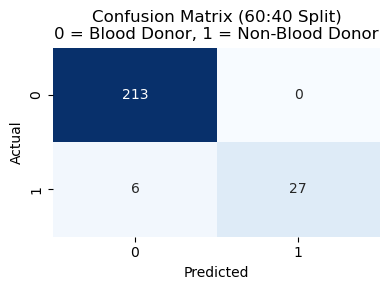

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# Load the preprocessed dataset
df = pd.read_excel("Preprocessed_Dataset.xlsx")

# Define features and target
selected_features = ['Age','Sex', 'ALB', 'ALP', 'ALT', 'AST', 'BIL','CHE', 'CHOL', 'CREA', 'GGT', 'PROT'] 
X = df[selected_features]
y = df['Target']

# Define the top 3 split ratios
split_ratios = [0.2, 0.3, 0.4]  # Corresponds to 80:20, 70:30, 60:40

# Generate confusion matrices
for test_ratio in split_ratios:
    train_ratio = 1 - test_ratio
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_ratio, random_state=42, stratify=y
    )

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix ({int(train_ratio*100)}:{int(test_ratio*100)} Split)\n0 = Blood Donor, 1 = Non-Blood Donor')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# Load the preprocessed dataset
df = pd.read_excel("Preprocessed_Dataset.xlsx")

# Define features and target
selected_features = ['Age','Sex', 'ALB', 'ALP', 'ALT', 'AST', 'BIL','CHE', 'CHOL', 'CREA', 'GGT', 'PROT'] 
X = df[selected_features]
y = df['Target']

# Define the best 3 split ratios: 80:20, 70:30, 60:40
split_ratios = [0.2, 0.3, 0.4]

# Function to compute sensitivity and specificity
def compute_sensitivity_specificity(cm):
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) else 0
    specificity = tn / (tn + fp) if (tn + fp) else 0
    return sensitivity, specificity

# Print results
for test_ratio in split_ratios:
    train_ratio = 1 - test_ratio
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_ratio, random_state=42, stratify=y
    )

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    sensitivity, specificity = compute_sensitivity_specificity(cm)

    print(f"\nTrain:Test = {int(train_ratio*100)}:{int(test_ratio*100)}")
    print("Confusion Matrix:\n", cm)
    print("Sensitivity (Recall for class 1 - Non-blood donor):", round(sensitivity, 3))
    print("Specificity (Correct detection of class 0 - Blood donor):", round(specificity, 3))


Train:Test = 80:20
Confusion Matrix:
 [[107   0]
 [  1  15]]
Sensitivity (Recall for class 1 - Non-blood donor): 0.938
Specificity (Correct detection of class 0 - Blood donor): 1.0

Train:Test = 70:30
Confusion Matrix:
 [[160   0]
 [  4  21]]
Sensitivity (Recall for class 1 - Non-blood donor): 0.84
Specificity (Correct detection of class 0 - Blood donor): 1.0

Train:Test = 60:40
Confusion Matrix:
 [[213   0]
 [  6  27]]
Sensitivity (Recall for class 1 - Non-blood donor): 0.818
Specificity (Correct detection of class 0 - Blood donor): 1.0


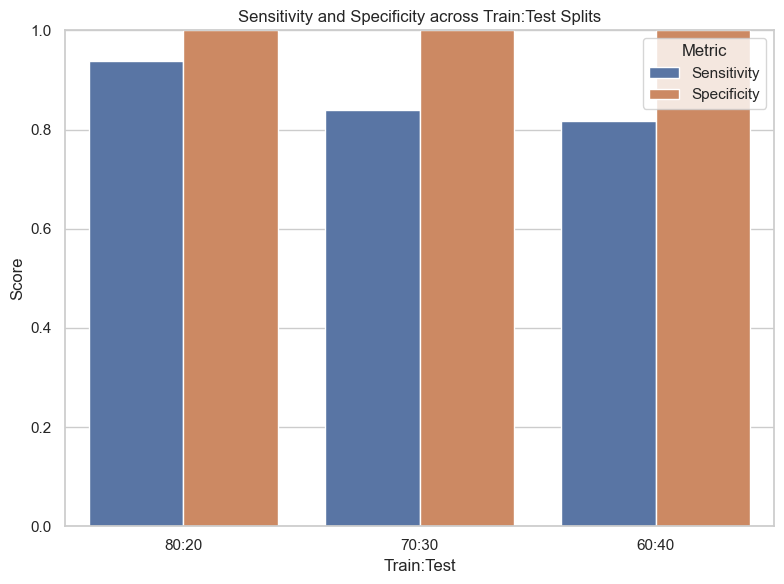

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Store results for visualization
results = []

for test_ratio in split_ratios:
    train_ratio = 1 - test_ratio
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_ratio, random_state=42, stratify=y
    )

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    sensitivity, specificity = compute_sensitivity_specificity(cm)

    # Append results
    results.append({
        "Train:Test": f"{int(train_ratio*100)}:{int(test_ratio*100)}",
        "Sensitivity": sensitivity,
        "Specificity": specificity
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Plot using seaborn
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")
results_melted = results_df.melt(id_vars="Train:Test", var_name="Metric", value_name="Score")
sns.barplot(x="Train:Test", y="Score", hue="Metric", data=results_melted)

plt.title("Sensitivity and Specificity across Train:Test Splits")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()